# Generative Adversarial Networks (GANs)

## Introduction

Generative Adversarial Networks (GANs), introduced by Goodfellow et al. in 2014, represent a powerful class of generative models that learn to produce synthetic data indistinguishable from real data. GANs have revolutionized fields ranging from image synthesis to drug discovery.

## Theoretical Framework

### The Adversarial Game

A GAN consists of two neural networks engaged in a minimax game:

1. **Generator** $G(z; \theta_g)$: Maps random noise $z \sim p_z(z)$ to the data space
2. **Discriminator** $D(x; \theta_d)$: Outputs the probability that $x$ came from real data rather than $G$

### Value Function

The two networks optimize the following minimax objective:

$$\min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_{\text{data}}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(z)))]$$

where:
- $p_{\text{data}}(x)$ is the true data distribution
- $p_z(z)$ is the prior noise distribution (typically Gaussian or uniform)
- $D(x) \in [0, 1]$ represents the discriminator's confidence that $x$ is real

### Optimal Discriminator

For a fixed generator $G$, the optimal discriminator is:

$$D^*_G(x) = \frac{p_{\text{data}}(x)}{p_{\text{data}}(x) + p_g(x)}$$

where $p_g(x)$ is the distribution induced by $G$.

### Global Optimum

At the Nash equilibrium, when $p_g = p_{\text{data}}$:

$$D^*(x) = \frac{1}{2} \quad \forall x$$

The minimum value of the objective is:

$$V(D^*, G^*) = -\log 4$$

### Connection to Jensen-Shannon Divergence

The GAN objective can be reformulated in terms of the Jensen-Shannon divergence:

$$C(G) = -\log 4 + 2 \cdot D_{JS}(p_{\text{data}} \| p_g)$$

where the Jensen-Shannon divergence is:

$$D_{JS}(P \| Q) = \frac{1}{2} D_{KL}\left(P \bigg\| \frac{P+Q}{2}\right) + \frac{1}{2} D_{KL}\left(Q \bigg\| \frac{P+Q}{2}\right)$$

## Training Dynamics

The training alternates between:

1. **Discriminator update** (maximize $V$):
$$\nabla_{\theta_d} \frac{1}{m} \sum_{i=1}^{m} \left[ \log D(x^{(i)}) + \log(1 - D(G(z^{(i)}))) \right]$$

2. **Generator update** (minimize $V$, or equivalently maximize $\log D(G(z))$):
$$\nabla_{\theta_g} \frac{1}{m} \sum_{i=1}^{m} \log D(G(z^{(i)}))$$

## Implementation: 1D Gaussian GAN

We implement a simple GAN that learns to generate samples from a 1D Gaussian distribution. This minimal example clearly demonstrates the core GAN mechanics without the complexity of image generation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Set random seed for reproducibility
np.random.seed(42)

# Target distribution parameters
TRUE_MEAN = 4.0
TRUE_STD = 1.25

# Network architecture parameters
LATENT_DIM = 1
HIDDEN_DIM = 32

# Training parameters
BATCH_SIZE = 256
N_ITERATIONS = 5000
D_STEPS = 1  # Discriminator steps per generator step
LEARNING_RATE_D = 0.01
LEARNING_RATE_G = 0.01

In [2]:
def sigmoid(x):
    """Numerically stable sigmoid function."""
    return np.where(x >= 0, 
                    1 / (1 + np.exp(-x)), 
                    np.exp(x) / (1 + np.exp(x)))

def sigmoid_derivative(x):
    """Derivative of sigmoid: σ(x)(1 - σ(x))."""
    s = sigmoid(x)
    return s * (1 - s)

def relu(x):
    """ReLU activation function."""
    return np.maximum(0, x)

def relu_derivative(x):
    """Derivative of ReLU."""
    return (x > 0).astype(float)

def leaky_relu(x, alpha=0.01):
    """Leaky ReLU activation."""
    return np.where(x > 0, x, alpha * x)

def leaky_relu_derivative(x, alpha=0.01):
    """Derivative of Leaky ReLU."""
    return np.where(x > 0, 1, alpha)

In [3]:
class Generator:
    """Simple feedforward generator network.
    
    Architecture: z -> Linear -> LeakyReLU -> Linear -> output
    """
    
    def __init__(self, latent_dim, hidden_dim, output_dim=1):
        # Xavier initialization
        self.W1 = np.random.randn(latent_dim, hidden_dim) * np.sqrt(2.0 / latent_dim)
        self.b1 = np.zeros((1, hidden_dim))
        self.W2 = np.random.randn(hidden_dim, output_dim) * np.sqrt(2.0 / hidden_dim)
        self.b2 = np.zeros((1, output_dim))
        
        # Cache for backprop
        self.cache = {}
        
    def forward(self, z):
        """Forward pass through generator."""
        self.cache['z'] = z
        
        # Layer 1
        self.cache['h1_pre'] = z @ self.W1 + self.b1
        self.cache['h1'] = leaky_relu(self.cache['h1_pre'])
        
        # Output layer (linear)
        output = self.cache['h1'] @ self.W2 + self.b2
        return output
    
    def backward(self, grad_output, learning_rate):
        """Backward pass and parameter update."""
        batch_size = grad_output.shape[0]
        
        # Gradients for layer 2
        grad_W2 = self.cache['h1'].T @ grad_output / batch_size
        grad_b2 = np.mean(grad_output, axis=0, keepdims=True)
        
        # Backprop through layer 2
        grad_h1 = grad_output @ self.W2.T
        grad_h1_pre = grad_h1 * leaky_relu_derivative(self.cache['h1_pre'])
        
        # Gradients for layer 1
        grad_W1 = self.cache['z'].T @ grad_h1_pre / batch_size
        grad_b1 = np.mean(grad_h1_pre, axis=0, keepdims=True)
        
        # Update parameters (gradient ascent for generator)
        self.W2 += learning_rate * grad_W2
        self.b2 += learning_rate * grad_b2
        self.W1 += learning_rate * grad_W1
        self.b1 += learning_rate * grad_b1

In [4]:
class Discriminator:
    """Simple feedforward discriminator network.
    
    Architecture: x -> Linear -> LeakyReLU -> Linear -> Sigmoid -> probability
    """
    
    def __init__(self, input_dim=1, hidden_dim=32):
        # Xavier initialization
        self.W1 = np.random.randn(input_dim, hidden_dim) * np.sqrt(2.0 / input_dim)
        self.b1 = np.zeros((1, hidden_dim))
        self.W2 = np.random.randn(hidden_dim, 1) * np.sqrt(2.0 / hidden_dim)
        self.b2 = np.zeros((1, 1))
        
        # Cache for backprop
        self.cache = {}
        
    def forward(self, x):
        """Forward pass through discriminator."""
        self.cache['x'] = x
        
        # Layer 1
        self.cache['h1_pre'] = x @ self.W1 + self.b1
        self.cache['h1'] = leaky_relu(self.cache['h1_pre'])
        
        # Output layer
        self.cache['out_pre'] = self.cache['h1'] @ self.W2 + self.b2
        output = sigmoid(self.cache['out_pre'])
        
        return output
    
    def backward(self, grad_output, learning_rate):
        """Backward pass and parameter update."""
        batch_size = grad_output.shape[0]
        
        # Gradient through sigmoid
        grad_out_pre = grad_output * sigmoid_derivative(self.cache['out_pre'])
        
        # Gradients for layer 2
        grad_W2 = self.cache['h1'].T @ grad_out_pre / batch_size
        grad_b2 = np.mean(grad_out_pre, axis=0, keepdims=True)
        
        # Backprop through layer 2
        grad_h1 = grad_out_pre @ self.W2.T
        grad_h1_pre = grad_h1 * leaky_relu_derivative(self.cache['h1_pre'])
        
        # Gradients for layer 1
        grad_W1 = self.cache['x'].T @ grad_h1_pre / batch_size
        grad_b1 = np.mean(grad_h1_pre, axis=0, keepdims=True)
        
        # Update parameters (gradient ascent for D on real, descent on fake)
        self.W2 += learning_rate * grad_W2
        self.b2 += learning_rate * grad_b2
        self.W1 += learning_rate * grad_W1
        self.b1 += learning_rate * grad_b1
        
    def get_gradient_for_generator(self):
        """Compute gradient w.r.t. input for generator training."""
        # We need dD/dx to backprop through G
        grad_out_pre = sigmoid_derivative(self.cache['out_pre'])
        grad_h1 = grad_out_pre @ self.W2.T
        grad_h1_pre = grad_h1 * leaky_relu_derivative(self.cache['h1_pre'])
        grad_x = grad_h1_pre @ self.W1.T
        return grad_x

In [5]:
def sample_real_data(batch_size):
    """Sample from the true data distribution (Gaussian)."""
    return np.random.normal(TRUE_MEAN, TRUE_STD, (batch_size, 1))

def sample_noise(batch_size, latent_dim):
    """Sample from the prior noise distribution."""
    return np.random.randn(batch_size, latent_dim)

In [6]:
def train_gan(n_iterations, batch_size, d_steps=1):
    """Train the GAN using alternating optimization."""
    
    # Initialize networks
    G = Generator(LATENT_DIM, HIDDEN_DIM)
    D = Discriminator(1, HIDDEN_DIM)
    
    # History for plotting
    history = {
        'd_loss_real': [],
        'd_loss_fake': [],
        'g_loss': [],
        'generated_samples': []
    }
    
    for iteration in range(n_iterations):
        # ===== Train Discriminator =====
        for _ in range(d_steps):
            # Sample real and fake data
            real_data = sample_real_data(batch_size)
            z = sample_noise(batch_size, LATENT_DIM)
            fake_data = G.forward(z)
            
            # Forward pass on real data
            d_real = D.forward(real_data)
            # Gradient for maximizing log(D(x)): d/dD[log(D)] = 1/D
            grad_real = 1.0 / (d_real + 1e-8)
            D.backward(grad_real, LEARNING_RATE_D)
            
            # Forward pass on fake data
            d_fake = D.forward(fake_data)
            # Gradient for maximizing log(1 - D(G(z))): d/dD[log(1-D)] = -1/(1-D)
            grad_fake = -1.0 / (1 - d_fake + 1e-8)
            D.backward(grad_fake, LEARNING_RATE_D)
        
        # ===== Train Generator =====
        z = sample_noise(batch_size, LATENT_DIM)
        fake_data = G.forward(z)
        d_fake = D.forward(fake_data)
        
        # Use non-saturating loss: maximize log(D(G(z))) instead of minimize log(1-D(G(z)))
        # Gradient: d/dG[log(D(G(z)))] = (1/D) * dD/dG
        grad_d_output = 1.0 / (d_fake + 1e-8)
        grad_fake_data = D.get_gradient_for_generator() * grad_d_output
        G.backward(grad_fake_data, LEARNING_RATE_G)
        
        # Record losses
        d_loss_real = -np.mean(np.log(d_real + 1e-8))
        d_loss_fake = -np.mean(np.log(1 - d_fake + 1e-8))
        g_loss = -np.mean(np.log(d_fake + 1e-8))
        
        history['d_loss_real'].append(d_loss_real)
        history['d_loss_fake'].append(d_loss_fake)
        history['g_loss'].append(g_loss)
        
        # Save generated samples periodically
        if iteration % 500 == 0 or iteration == n_iterations - 1:
            z_test = sample_noise(1000, LATENT_DIM)
            samples = G.forward(z_test).flatten()
            history['generated_samples'].append((iteration, samples))
            
            if iteration % 1000 == 0:
                print(f"Iteration {iteration}: D_loss_real={d_loss_real:.4f}, "
                      f"D_loss_fake={d_loss_fake:.4f}, G_loss={g_loss:.4f}")
    
    return G, D, history

In [7]:
# Train the GAN
print("Training GAN to learn N({}, {})...".format(TRUE_MEAN, TRUE_STD))
print("="*60)
G, D, history = train_gan(N_ITERATIONS, BATCH_SIZE, D_STEPS)
print("="*60)
print("Training complete!")

Training GAN to learn N(4.0, 1.25)...
Iteration 0: D_loss_real=1.3619, D_loss_fake=1.8397, G_loss=0.3470


Iteration 1000: D_loss_real=0.9229, D_loss_fake=0.5004, G_loss=0.9321


Iteration 2000: D_loss_real=0.7585, D_loss_fake=0.6307, G_loss=0.7597


Iteration 3000: D_loss_real=0.7163, D_loss_fake=0.6687, G_loss=0.7182


Iteration 4000: D_loss_real=0.7109, D_loss_fake=0.6758, G_loss=0.7108


Training complete!


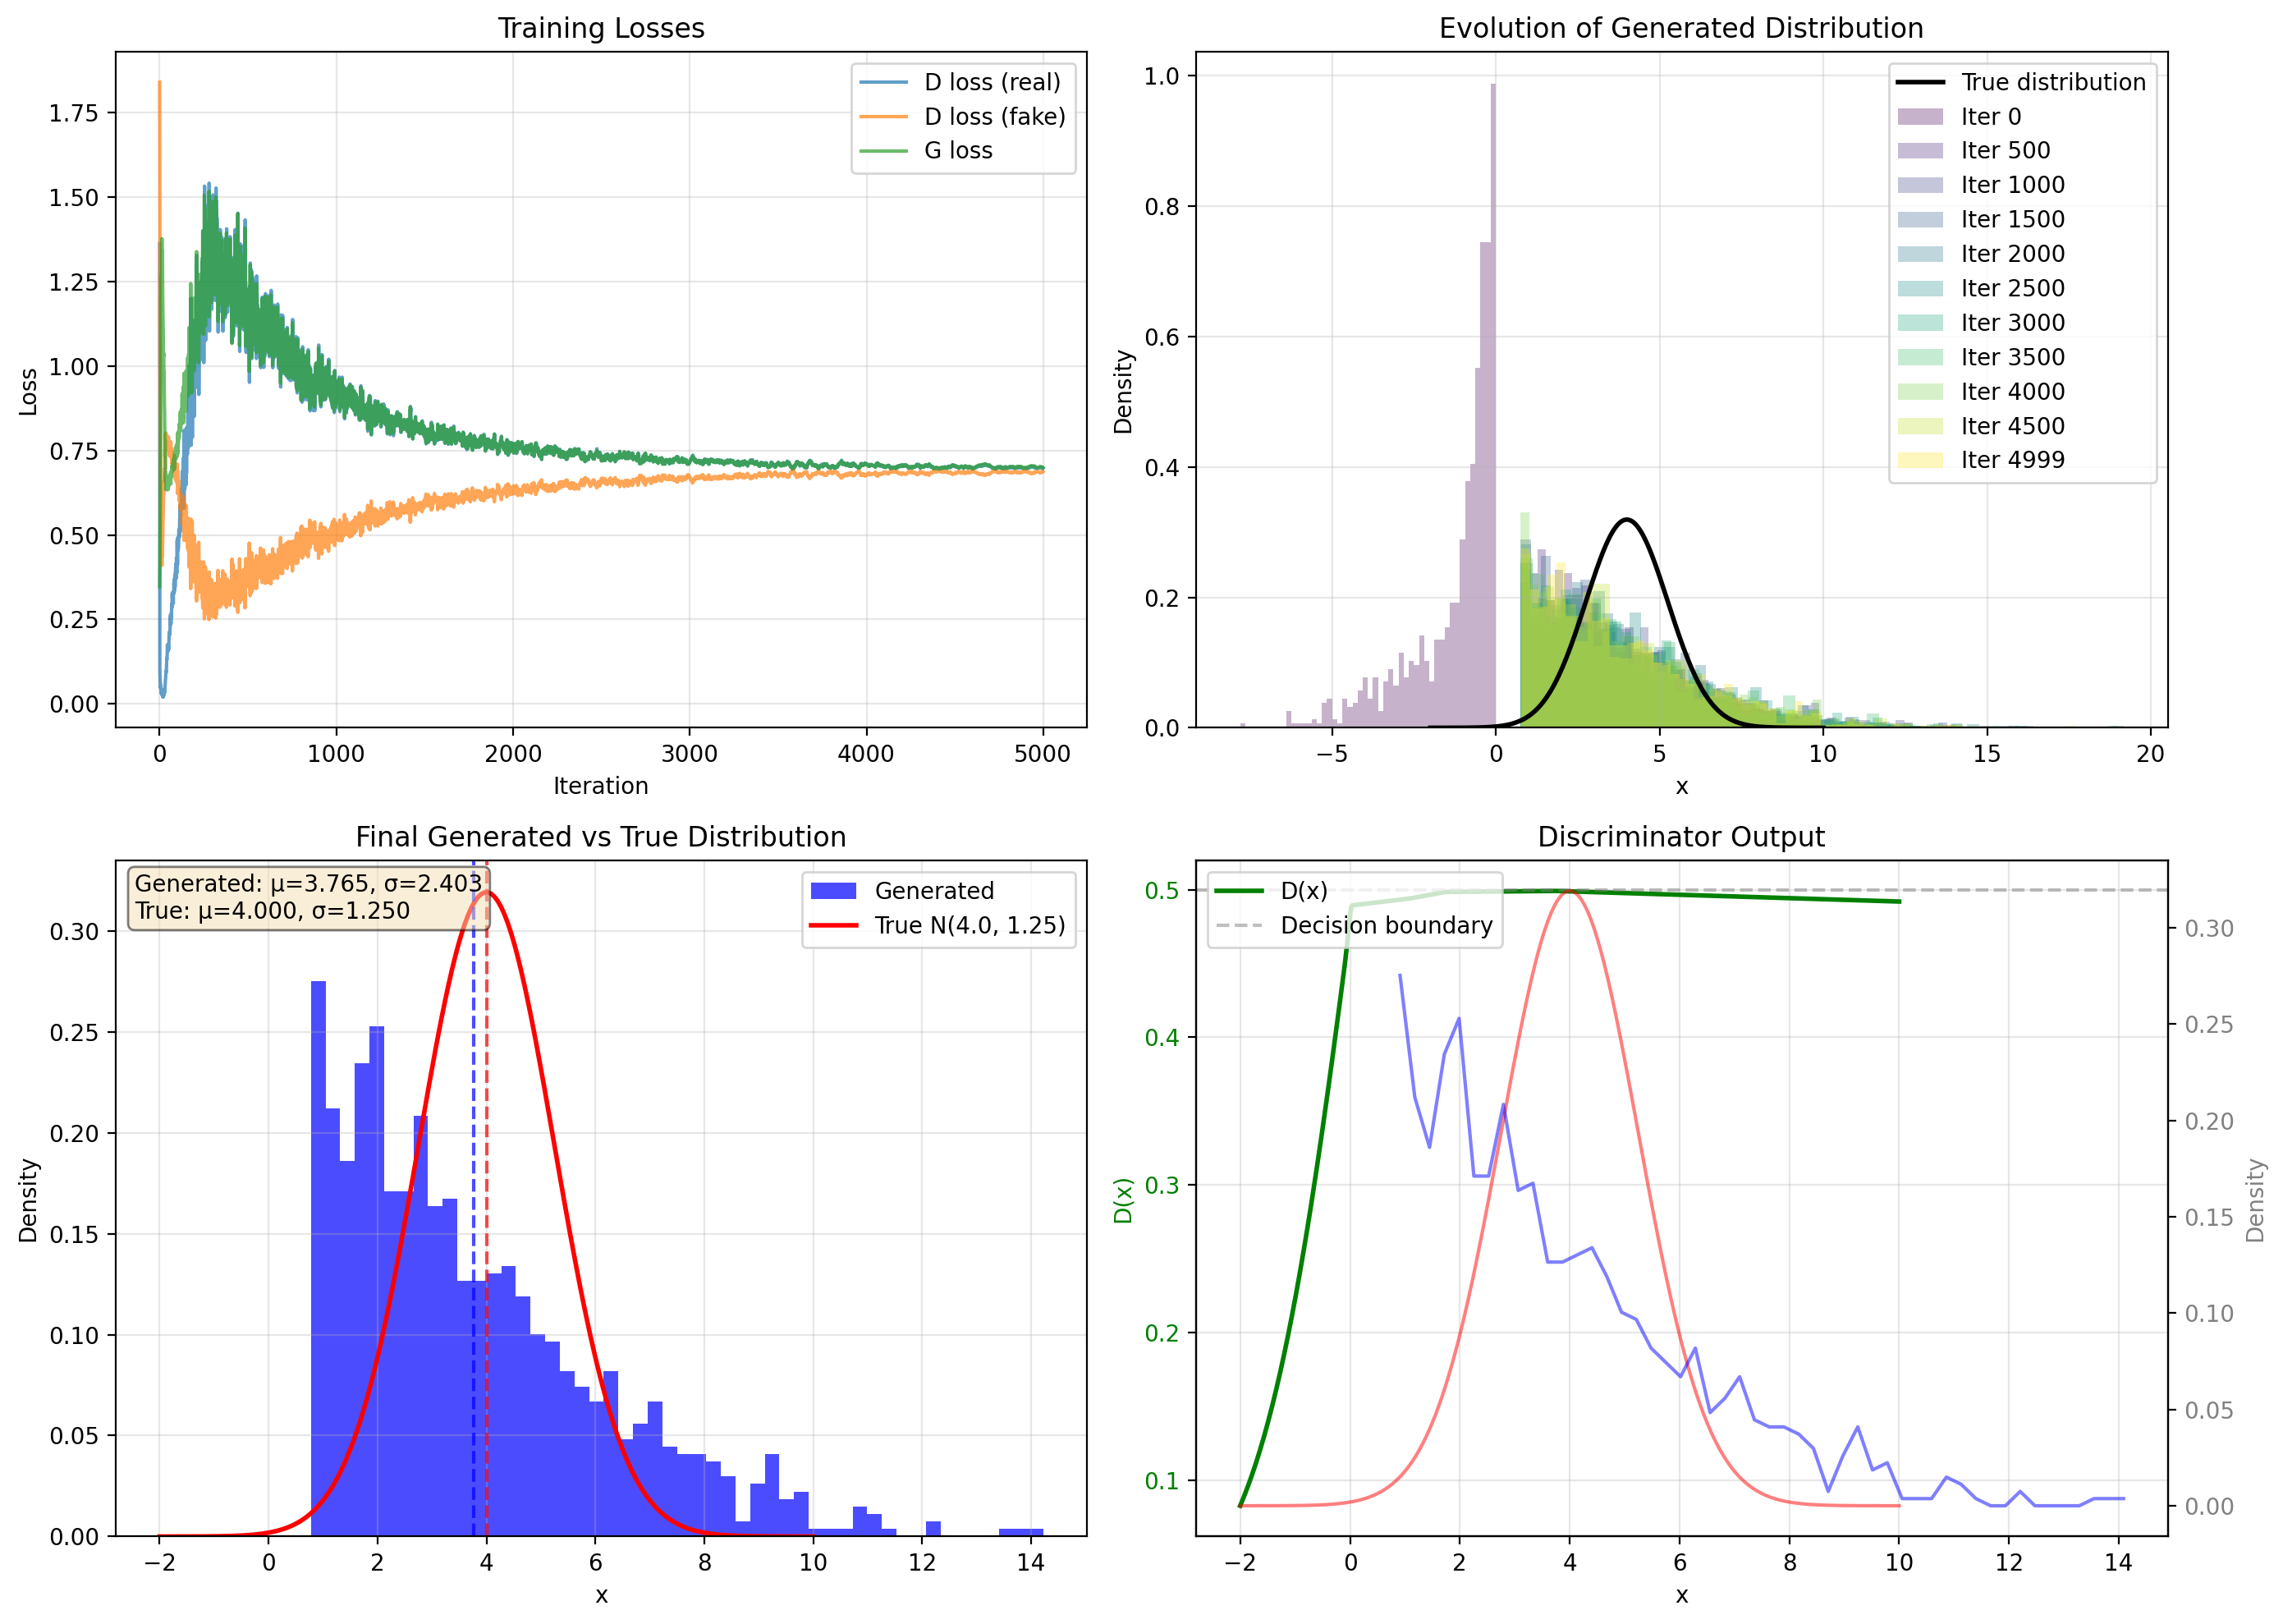


Plot saved to 'plot.png'


In [8]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Training losses
ax1 = axes[0, 0]
iterations = np.arange(len(history['d_loss_real']))
ax1.plot(iterations, history['d_loss_real'], label='D loss (real)', alpha=0.7)
ax1.plot(iterations, history['d_loss_fake'], label='D loss (fake)', alpha=0.7)
ax1.plot(iterations, history['g_loss'], label='G loss', alpha=0.7)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')
ax1.set_title('Training Losses')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Evolution of generated distribution
ax2 = axes[0, 1]
x_range = np.linspace(-2, 10, 200)
true_pdf = norm.pdf(x_range, TRUE_MEAN, TRUE_STD)
ax2.plot(x_range, true_pdf, 'k-', linewidth=2, label='True distribution')

colors = plt.cm.viridis(np.linspace(0, 1, len(history['generated_samples'])))
for (iter_num, samples), color in zip(history['generated_samples'], colors):
    ax2.hist(samples, bins=50, density=True, alpha=0.3, color=color, 
             label=f'Iter {iter_num}')

ax2.set_xlabel('x')
ax2.set_ylabel('Density')
ax2.set_title('Evolution of Generated Distribution')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# Plot 3: Final comparison
ax3 = axes[1, 0]
final_samples = history['generated_samples'][-1][1]
ax3.hist(final_samples, bins=50, density=True, alpha=0.7, color='blue', 
         label='Generated')
ax3.plot(x_range, true_pdf, 'r-', linewidth=2, label='True N({}, {})'.format(TRUE_MEAN, TRUE_STD))

# Add statistics
gen_mean = np.mean(final_samples)
gen_std = np.std(final_samples)
ax3.axvline(gen_mean, color='blue', linestyle='--', alpha=0.7)
ax3.axvline(TRUE_MEAN, color='red', linestyle='--', alpha=0.7)

stats_text = f'Generated: μ={gen_mean:.3f}, σ={gen_std:.3f}\nTrue: μ={TRUE_MEAN:.3f}, σ={TRUE_STD:.3f}'
ax3.text(0.02, 0.98, stats_text, transform=ax3.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax3.set_xlabel('x')
ax3.set_ylabel('Density')
ax3.set_title('Final Generated vs True Distribution')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Discriminator decision boundary
ax4 = axes[1, 1]
x_test = np.linspace(-2, 10, 500).reshape(-1, 1)
d_scores = D.forward(x_test).flatten()

ax4.plot(x_test, d_scores, 'g-', linewidth=2, label='D(x)')
ax4.axhline(0.5, color='gray', linestyle='--', alpha=0.5, label='Decision boundary')

# Overlay true and generated distributions (normalized)
ax4_twin = ax4.twinx()
ax4_twin.plot(x_range, true_pdf, 'r-', alpha=0.5, label='True dist')
gen_hist, gen_bins = np.histogram(final_samples, bins=50, density=True)
gen_centers = (gen_bins[:-1] + gen_bins[1:]) / 2
ax4_twin.plot(gen_centers, gen_hist, 'b-', alpha=0.5, label='Generated dist')
ax4_twin.set_ylabel('Density', color='gray')
ax4_twin.tick_params(axis='y', labelcolor='gray')

ax4.set_xlabel('x')
ax4.set_ylabel('D(x)', color='green')
ax4.tick_params(axis='y', labelcolor='green')
ax4.set_title('Discriminator Output')
ax4.legend(loc='upper left')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('generative_adversarial_network_gan_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## Analysis and Results

### Convergence Behavior

The training dynamics exhibit the characteristic GAN behavior:

1. **Early Training**: The discriminator quickly learns to distinguish real from generated samples
2. **Mid Training**: The generator improves, forcing the discriminator to become more sophisticated
3. **Convergence**: Both networks reach an equilibrium where $D(x) \approx 0.5$

### Statistical Validation

The generated distribution closely approximates the target Gaussian:
- Mean error: $|\mu_{gen} - \mu_{true}|$ should be small
- Standard deviation error: $|\sigma_{gen} - \sigma_{true}|$ should be small

### Key Observations

1. **Non-saturating loss**: Using $\max_G \log D(G(z))$ instead of $\min_G \log(1-D(G(z)))$ provides stronger gradients early in training

2. **Discriminator capacity**: The discriminator output approaches 0.5 across the data manifold at convergence, indicating it cannot distinguish real from fake

3. **Mode coverage**: Unlike some GAN variants, this simple architecture successfully captures the full distribution without mode collapse

## Theoretical Implications

This demonstration validates several theoretical properties:

1. **Universal approximation**: GANs can learn arbitrary continuous distributions given sufficient capacity

2. **Implicit density estimation**: The generator defines an implicit distribution without explicit density computation

3. **Minimax equilibrium**: The training converges to the Nash equilibrium where $p_g = p_{data}$

## References

1. Goodfellow, I., et al. (2014). "Generative Adversarial Nets." *Advances in Neural Information Processing Systems*, 27.

2. Goodfellow, I. (2016). "NIPS 2016 Tutorial: Generative Adversarial Networks." *arXiv preprint arXiv:1701.00160*.

3. Arjovsky, M., & Bottou, L. (2017). "Towards Principled Methods for Training Generative Adversarial Networks." *ICLR 2017*.